# Transfer learning for face analysis


by Clément Rebut, Matthew Rousseau and Sophie Starck

The goal of this notebook is to present two methods for face comparison: given two faces, our model will be able to tell if it is the same or not. We first explore a simple distance between two set of features, and then a siamese architecture, with a comparative performance analysis.

* [Data Management](#dataman)
* [Euclidean Distance](#euclidean)
* [Siamese Architecture](#siamese)
* [Comparative Performance analysis](#analysis)
* [Demo](#demo)



**Package installations**

In [1]:
import tensorflow
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
!pip install keras_applications 
!pip install keras_vggface

In [3]:
from keras_vggface.vggface import VGGFace
import keras_vggface
import keras_applications

## Data management <a class="anchor" id="dataman"></a>

### Data loading

In [4]:
path = "../TP2/cacd_vs_img_bgr_preprocessed.npz"

data = np.load(path, allow_pickle=True)
data.files

['x_0', 'x_1', 'y', 'orig_ids']

In [5]:
x_0 = data['x_0']
x_1 = data['x_1']
y = data['y']

### Data Visualisation

In [6]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

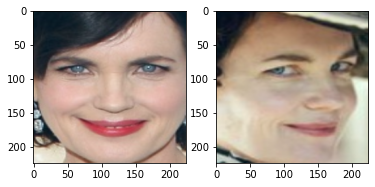

Y = 1


In [7]:
# positive pair
plt.subplot(121)

img_float = x_0[100]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(to_rgb(img_disp))

plt.subplot(122)
img_float = x_1[100]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(to_rgb(img_disp))
plt.show()
print(f"Y = {y[100]}")

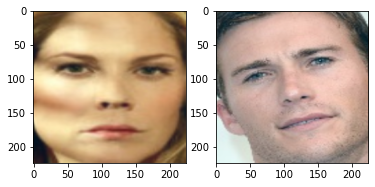

Y = 0


In [8]:
# negative pair
plt.subplot(121)

img_float = x_0[200]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(to_rgb(img_disp))

plt.subplot(122)
img_float = x_1[200]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(to_rgb(img_disp))
plt.show()
print(f"Y = {y[200]}")

In [9]:
del(img_float)
del(img_disp)

## Euclidean distance <a class="anchor" id="euclidean"></a>
The goal in the practical was to use vggface to compute features on the faces and then compute the distance between the features of two faces to determine if they were the same person or not. We are using a `resnet50` backend because it gave better results.

In [10]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

We first compute the features for all faces.

In [11]:
Y_pred_0 = vggface.predict(x_0[:400])
Y_pred_1 = vggface.predict(x_1[:400])

We then compute the distance between each pair of faces from the extracted features.

In [12]:
# euclidean distance
dist = np.array([np.linalg.norm(Y_pred_1[i]-Y_pred_0[i], ord=2) for i in range(400)])

In [13]:
del(Y_pred_0)
del(Y_pred_1)

We now verify that the two classes can be distiguished from only the distance.

In [14]:
print(dist[y[:400]==0].mean(), dist[y[:400]==1].mean())

133.90572 86.75831


We can notice that the mean of the two classes is different so we will be able to classify the data to a certain degree.

Now We want to display the histograms to check for the distribution of both classes and also their cumulative distribution function.

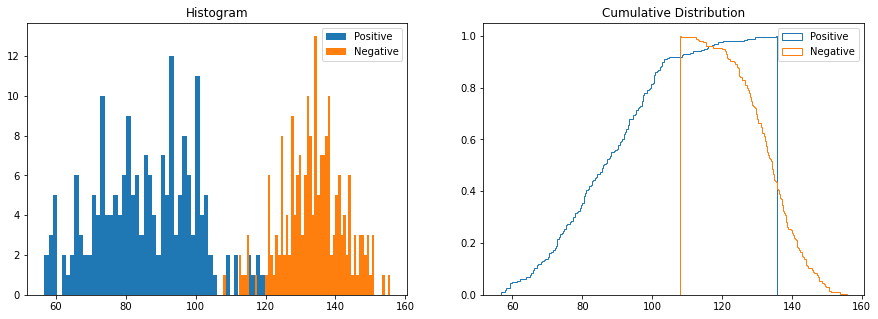

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
# positive matches
plt.hist(dist[:200], bins=64, label='Positive')
# negative matches
plt.hist(dist[200:],bins=64, label='Negative')
plt.title("Histogram")
plt.legend()

plt.subplot(122)
# positive matches
plt.hist(dist[:200], bins=200, density=True, histtype='step', cumulative=1, label='Positive')
# negative matches
plt.hist(dist[200:], bins=200, density=True, histtype='step', cumulative=-1, label='Negative')
plt.title("Cumulative Distribution")
plt.legend()
plt.show()

In [16]:
dist = 1 - (dist - min(dist))/(max(dist) - min(dist))

### Computing the threshold

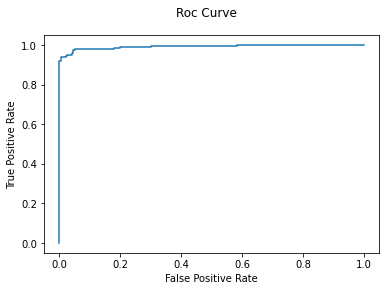

area under the curve = 0.9920249999999999


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y[:400], dist)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('Roc Curve')
plt.show()
print(f"area under the curve = {roc_auc_score(y[:400], dist)}")

We can notice that the area under the ROC curve is quite high, which is what we want for a good classification result.

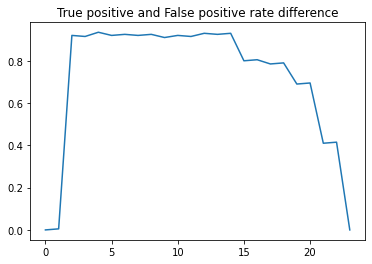

In [18]:
plt.plot(tpr-fpr)
plt.title('True positive and False positive rate difference')
plt.show()

We are computing the difference between the true positive and false positive rates to decide which threshold we should use. We wanted to experiment with automatically choosing the best threshold and we came up with this metric from the ROC curve. We could probably weight the rates in order to adapt the threshold based on user preferences.

x:4, fpr:0.005, tpr:0.94, threshold:0.4440177083015442


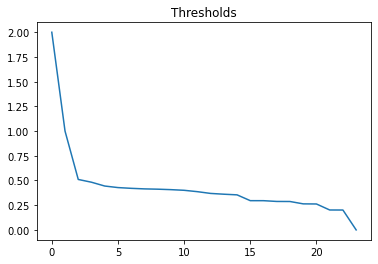

In [19]:
x = np.argmax(tpr-fpr)
print(f'x:{x}, fpr:{fpr[x]}, tpr:{tpr[x]}, threshold:{thresholds[x]}')
plt.plot(thresholds)
plt.title('Thresholds')
plt.show()

Now that we decided which false positive rate we can tolerate, we can select the corresponding threshold that will be used for the classification.

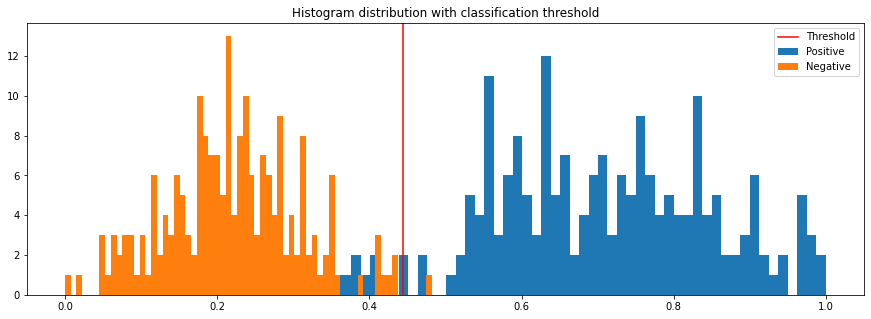

In [20]:
plt.figure(figsize=(15, 5))

# positive matches
plt.hist(dist[:200], bins=64, label='Positive')
# negative matches
plt.hist(dist[200:],bins=64, label='Negative')

plt.axvline(x=thresholds[x], c='r', label='Threshold')
plt.legend()
plt.title('Histogram distribution with classification threshold')
plt.show()

We can see that the threshold is located between both classes. We can also notice that in this case, the false negative rate might be a bit high.

### Classification

Now that we know the threshold between both classes, we can apply this threshold to our distances to generate a prediction.

In [21]:
dist[dist < thresholds[x]] = 0
dist[dist >= thresholds[x]] = 1

In [22]:
sklearn.metrics.accuracy_score(y[:400], dist)

0.9675

In [23]:
del(dist)
del(fpr)
del(tpr)

Our accuracy is 96% on the training set, which is quite good considering how simple our method is.

### Prediction on other values
We now want to check that our method works on another dataset. Thus we are using a verification dataset and running all the steps necessary to classify each sample:
- Compute the features using vggface
- Compute the distance between pairs of points
- Check the distance against the threshold we computed in the previous section

In [24]:
Y_test_0 = vggface.predict(x_0[400:800])
Y_test_1 = vggface.predict(x_1[400:800])

In [25]:
dist_test = [np.linalg.norm(Y_test_0[i]-Y_test_1[i]) for i in range(400)]
dist_test = 1 - (dist_test - min(dist_test))/(max(dist_test) - min(dist_test) + 0.0001)

In [26]:
del(Y_test_0)
del(Y_test_1)

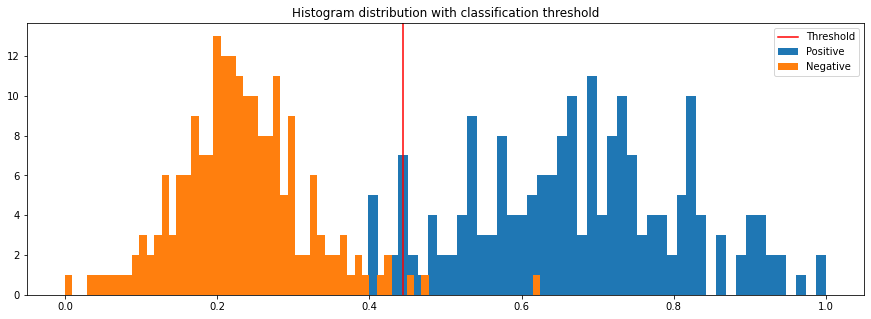

In [27]:
plt.figure(figsize=(15, 5))

# positive matches
plt.hist(dist_test[:200], bins=64, label='Positive')
# negative matches
plt.hist(dist_test[200:],bins=64, label='Negative')

plt.axvline(x=thresholds[x], c='r', label='Threshold')
plt.legend()
plt.title('Histogram distribution with classification threshold')

plt.show()

We can see from the distance histogram that both classes are still well separated and that the threshold we computed before still is in a reasonnable spot for a proper classification.

Now we run the prediction and check the accuracy:

In [28]:
dist_test[dist_test < thresholds[x]] = 0
dist_test[dist_test >= thresholds[x]] = 1

In [29]:
sklearn.metrics.accuracy_score(y[400:800], dist_test)

0.945

In [30]:
del(dist_test)

We obtained an 94% accuracy which is pretty high considering the simplicity of the method. We still have a 6% error rate, that we might want to reduce in a production environment.

Therefore, we will explore another classification method based on a siamese architecture in the next section, and we are hoping that it will give better results.

## Siamese architecture <a class="anchor" id="siamese"></a>

We expose, in this section, another method for comparing two faces based on a siamese architecture.

In [25]:
del(data)

### Dataset creation

In [26]:
# Normalize data
x_0 = x_0 / 255.
x_1 = x_1 / 255.

x_0.min(), x_0.max()

(-0.51408315, 0.6411949)

We want to produce three inputs to the model: the two images and the label, but a classic generator only produces two, traditionnaly one image and one label. So we had to implement a custom generator to produce the type of data we needed to feed to the network, in our case: `(image, image) and label`

In [27]:
from keras.utils import Sequence

class Mygenerator(Sequence):
    def __init__(self, x1, x2, y, batch_size):
        self.x1, self.x2, self.y = x1, x2, y
        self.batch_size = batch_size
        self.indices = np.arange(self.x1.shape[0])

    def __len__(self):
        return len(self.x1) // self.batch_size

    def __getitem__(self, idx):
        x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size]
        x2 = self.x2[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [np.array(x1), np.array(x2)], np.array(y)
    
    def on_epoch_end(self):
        # random order on the images
        np.random.shuffle(self.indices)


Here we split our data into three distinctive sections:
- **Training set**: data used for training the model.
- **Validation set**: data used at the end of each epoch to check whether it is overfitting or not.
- **Test set**: data used to assess the performance of the model after the training.

In [28]:
from sklearn.model_selection import train_test_split

X0, X0_test, X1, X1_test, Y, y_test = train_test_split(x_0, x_1, y, test_size=0.1, random_state=42)

In [29]:
shape = x_0.shape

# freeup RAM for google colab
del(x_0)
del(x_1)
del(y)

In [30]:
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(X0, X1, Y, test_size=0.33, random_state=42)

In [31]:
# freeup RAM for google colab
del(X0)
del(Y)
del(X1)

### Model definition

In [32]:
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten, Lambda, merge, Dropout
from sklearn.metrics.pairwise import manhattan_distances
import tensorflow as tf
import keras.backend as K

A siamese model is structured as follows: the same network is used to compute features on both images and a manhattan distance is computed over these feature vectors.

In [33]:
def siamese_model(vggface, input_shape):
    input_left = Input(input_shape)
    input_right = Input(input_shape)

    # We use the same model for both inputs 
    model_1 = vggface(input_left, training=False)
    model_2 = vggface(input_right, training=False)

    L1_layer = Lambda(lambda models: K.abs(models[0] - models[1]))

    # Add the distance function to the network
    dist_layer = L1_layer([model_1, model_2])
    out = Dense(128, activation='sigmoid')(dist_layer)
    out = Dense(1, activation='sigmoid')(out)

    return Model(inputs=[input_left, input_right], outputs=out)

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = 'siamese.h5'
# we use checkpoints to save the weights of our model
callbacks = [
             ModelCheckpoint(
                 filepath=checkpoint_filepath,
                 save_weights_only=True,
                 monitor='val_accuracy',
                 mode='max',
                 verbose=1,
                 save_best_only=True
                 ),]

In [35]:
from keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, Nadam, SGD

input_shape = shape[1:]
vggface = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

# We freeze the layers from the base model
vggface.trainable = False

EPOCHS = 100
BATCH_SIZE = 32
LR = 0.0001

model = siamese_model(vggface, input_shape)

print(model.summary())

optimizer = Adam(lr=LR, decay=LR/EPOCHS)

model.compile(loss="binary_crossentropy",
              optimizer= optimizer,
              metrics=['accuracy'])

58916864/58909280 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_vgg16 (Functional)      (None, 512)          14714688    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)       

### Model training

In [36]:
train_generator = Mygenerator(X0_train, X1_train, y_train, BATCH_SIZE)
val_generator = Mygenerator(X0_val, X1_val, y_val, BATCH_SIZE)

siamese_history = model.fit(
     train_generator,
     validation_data=val_generator,
     epochs=EPOCHS,
     callbacks=callbacks,
 )

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.4929
Epoch 00001: val_accuracy improved from -inf to 0.51436, saving model to siamese.h5
75/75 [==============================] - 15s 202ms/step - loss: 0.7695 - accuracy: 0.4929 - val_loss: 0.7219 - val_accuracy: 0.5144
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.4929
Epoch 00002: val_accuracy did not improve from 0.51436
75/75 [==============================] - 15s 194ms/step - loss: 0.7171 - accuracy: 0.4929 - val_loss: 0.7029 - val_accuracy: 0.5144
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.4929
Epoch 00003: val_accuracy did not improve from 0.51436
75/75 [==============================] - 14s 193ms/step - loss: 0.7015 - accuracy: 0.4929 - val_loss: 0.6949 - val_accuracy: 0.5144
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.4929
Epoch 00004: val_accuracy did 

Epoch 58/100
75/75 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.9171
Epoch 00058: val_accuracy did not improve from 0.90794
75/75 [==============================] - 15s 194ms/step - loss: 0.3914 - accuracy: 0.9171 - val_loss: 0.3943 - val_accuracy: 0.8986
Epoch 59/100
75/75 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.9171
Epoch 00059: val_accuracy did not improve from 0.90794
75/75 [==============================] - 14s 192ms/step - loss: 0.3875 - accuracy: 0.9171 - val_loss: 0.3903 - val_accuracy: 0.8986
Epoch 60/100
75/75 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.9171
Epoch 00060: val_accuracy did not improve from 0.90794
75/75 [==============================] - 14s 191ms/step - loss: 0.3837 - accuracy: 0.9171 - val_loss: 0.3869 - val_accuracy: 0.8986
Epoch 61/100
75/75 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.9167
Epoch 00061: val_accuracy did not improve from 0.90794


Epoch 87/100
75/75 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.9246
Epoch 00087: val_accuracy did not improve from 0.90794
75/75 [==============================] - 14s 193ms/step - loss: 0.3007 - accuracy: 0.9246 - val_loss: 0.3087 - val_accuracy: 0.9062
Epoch 88/100
75/75 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.9258
Epoch 00088: val_accuracy did not improve from 0.90794
75/75 [==============================] - 14s 192ms/step - loss: 0.2981 - accuracy: 0.9258 - val_loss: 0.3062 - val_accuracy: 0.9071
Epoch 89/100
75/75 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9254
Epoch 00089: val_accuracy did not improve from 0.90794
75/75 [==============================] - 14s 192ms/step - loss: 0.2957 - accuracy: 0.9254 - val_loss: 0.3044 - val_accuracy: 0.9071
Epoch 90/100
75/75 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.9250
Epoch 00090: val_accuracy did not improve from 0.90794


In [49]:
siamese_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

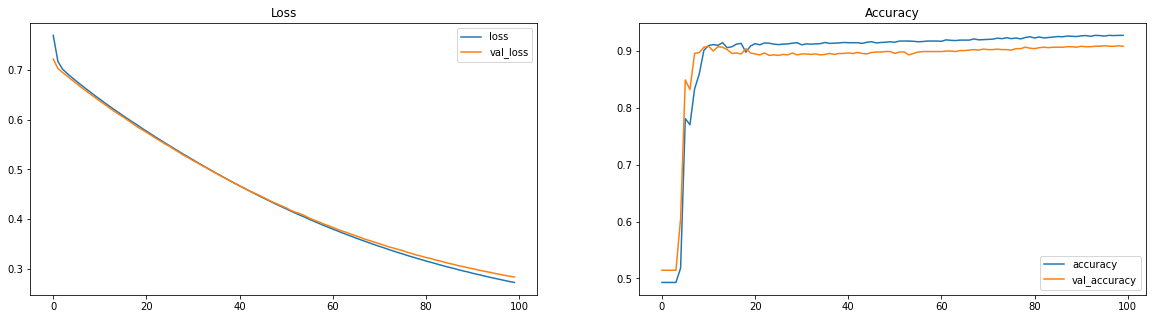

In [50]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(siamese_history.history['loss'], label='loss')
plt.plot(siamese_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.subplot(122)
plt.plot(siamese_history.history['accuracy'], label='accuracy')
plt.plot(siamese_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

If we look at the training curves here we can see that there is no overfitting (the curves follow pretty much the same trajectory) and the accuracy curve converges pretty fast but seems to get stuck right below 92%.

In [51]:
K.clear_session()

### Model testing

In [52]:
y_pred = model.predict([X0_test, X1_test],
                      batch_size=BATCH_SIZE,
                      verbose=1)

13/13 [==============================] - 2s 122ms/step


In [53]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<=0.5] = 0

In [54]:
from keras.metrics import Accuracy

results = model.evaluate([X0_test, X1_test], y_test)

13/13 [==============================] - 1s 115ms/step - loss: 0.2533 - accuracy: 0.9400


In [55]:
print("test loss, test accuracy:", results)

test loss, test accuracy: [0.25330838561058044, 0.9399999976158142]


We tried different approaches to improve the performances of our model:
- **Data augmentation**: we introduced a horizontal flip, thinking it might be interesting with face orientation and asymetry. Unfortunately, we lacked ressources (RAM) on this part and we were not able to integrate this...
- **Fine tuning**: We tried using a fine tuning method to obtain a better accuracy, but we only observed overfitting and it did not improve the overall results so we abandoned this lead.
- **Improve feature quality**: We added `Conv2d` layers before the distance layer in the model, to increase the number of features and maybe alter them a bit. This method did not prove to be effective: we did not surpass 70% so we abandoned the idea.

Overall our model seems to attain highest accuracy with the simplest architecure.

## Comparative performance analysis <a class="anchor" id="analysis"></a>

We expose here the performaces of both methods on the same dataset.


### Euclidean Distance

In [56]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [57]:
%%time

Y_pred_0 = vggface.predict(X0_test*255)
Y_pred_1 = vggface.predict(X1_test*255)
dist = np.array([np.linalg.norm(Y_pred_1[i]-Y_pred_0[i], ord=2) for i in range(400)])

dist = 1 - (dist - min(dist))/(max(dist) - min(dist))

dist[dist < thresholds[x]] = 0
dist[dist >= thresholds[x]] = 1
acc_dist = sklearn.metrics.accuracy_score(y_test, dist)

CPU times: user 2.35 s, sys: 395 ms, total: 2.75 s
Wall time: 2.72 s


### Siamese model

In [58]:
%%time

y_pred = model.predict([X0_test, X1_test])
y_pred[y_pred>0.5] = 1
y_pred[y_pred<=0.5] = 0

acc_siamese= sklearn.metrics.accuracy_score(y_test, np.squeeze(y_pred))

CPU times: user 1.68 s, sys: 316 ms, total: 2 s
Wall time: 1.89 s


In [59]:
print(f"Accuracy with euclidean distance: {acc_dist}")
print(f"Accuracy with siamese architecture: {acc_siamese}")


Accuracy with euclidean distance: 0.945
Accuracy with siamese architecture: 0.94


If we look at the accuracies there is not a big difference between the two methods. Given the fact that the performances are almost the same, there is no simple answer as to, which one is best.
- If the application is time critical (realtime face detection), the siamese architecture might be best  because the inference is faster.
- In the case of a "short deadline" for example, the first one is best because it is easier to setup, and there is no training time.

## Demo <a class="anchor" id="demo"></a>

We implemented a simple app to demonstrate our siamese network. This app detects a face on a videostream and uses the siamese model to predict whether or not it is the same as a reference image. The reference image can be chosen from the computer filesystem or captured directly on the videostream.  
This type of software could be used for a face recognition problem, to unlock computers or phones for instance.

The source code is located at this address: https://github.com/mattrouss/face-verification/tree/main it can be downloaded and executed from there.

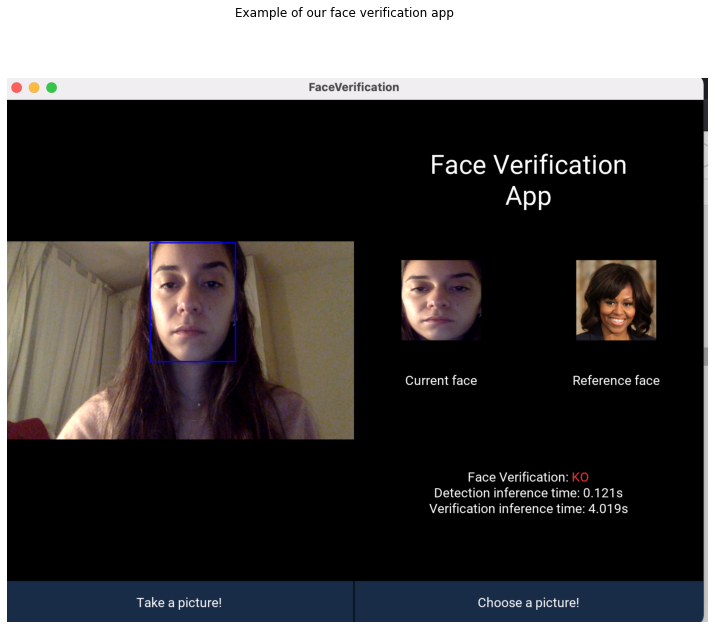

In [49]:
from skimage.io import imread
plt.figure(figsize=(15, 10))
im = imread("../input/example/Screenshot 2020-12-26 at 18.48.24.png")
plt.imshow(im)
plt.suptitle("Example of our face verification app")
plt.axis('off')
plt.show()